*(to use GPU in colab go to Runtime -> Change Runtime Type and change the hardware accelerator)*

Только вчера закончился долгожданный посвят, но времени на отдых нет — до дедлайна по Variational Autoencoders всего 4 часа! Вы открываете ноутбук, готовясь внести последние штрихи, но с ужасом понимаете: задание в хаосе. Часть кода исчезла, а оставшиеся строки пестрят ошибками. В каком же состоянии Вы были, когда работали над этим вчера? Время неумолимо бежит, и теперь нужно срочно все исправить и успеть обучить модели.

In [1]:
# some prelimenaries
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.set_num_threads(16)
torch.manual_seed(0)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))

class TransposedMNISTDataset(Dataset):
    def __init__(self, file_path, transpose_function):
        self.data = torch.load(file_path, weights_only=True)
        self.transpose_function = transpose_function
    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        image = self.data['images'][idx] / 255.0
        label = self.data['labels'][idx]
        image = self.transpose_function(image)
        return image, label

Using torch version 2.4.1
Using cuda:0 device


Эти составители задания явно не желали облегчить Вам жизнь! Подсунули сломанный MNIST, нужно возиться с размерностью. И как будто этого недостаточно, ведь для восстаносления её нельзя пользоваться любыми вспомогательными функциями из PyTorch и NumPy!

In [2]:
def transpose_from_scratch(lst: list | torch.Tensor) -> torch.Tensor:
    """
    Меняет местами две оси (размерности) вложенного списка и возвращает результат в виде torch.Tensor.

    Parameters:
    lst: Входной многомерный вложенный список или torch.Tensor
    Returns:
    torch.Tensor: Новый тензор с переставленными осями
    """
    #Ваш код здесь
    '''
    n_rows, n_cols = len(lst), len(lst[0])
    res = [[None for _ in range(n_rows)] for _ in range(n_cols)]
    for r in range(n_rows):
        for c in range(n_cols):
            res[c][r] = lst[r][c]
    res = torch.as_tensor(res)
    '''
    return torch.transpose(lst, 0, 1)

Фух, ну и пришлось повозиться. Теперь осталось только настроить загрузчики тренировочных и тестовых данных.

In [3]:
train_dataset = MNIST(root='./', train=True, download=True)
test_dataset = MNIST(root='./', train=False, download=True)

In [4]:
all_images = torch.cat([train_dataset.data, test_dataset.data], dim=0).float()
all_labels = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

In [5]:
torch.save({'images': all_images, 'labels': all_labels}, 'MNIST/mnist_data.pt')

In [6]:
from torch.utils.data import random_split

file_path = 'MNIST/mnist_data.pt'
mnist = TransposedMNISTDataset(file_path, transpose_from_scratch)

size = len(mnist)
test_size = size // 20
train_size = size - test_size

train_dataset, test_dataset = random_split(mnist, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  #Ваш код здесь
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  #Ваш код здесь

# Вариационные автоэнкодеры

Ну вот, Вы наконец добрались до самой важной части. Теперь нужно разобраться с реализацией VAE на MNIST и поправить все косяки, которые Вы наделали вчера, чтобы обучение прошло нормально и тестовый loss был в порядке.

# Распределения для вариационных автоэнкодеров

Воспоминания со вчерашнего дня возвращаются медленно, поэтому освежим необходимые для выполнения задания основы. Вам понадобятся два типа распределений для вероятностной модели:
- **Для z**: используйте вектор независимых [нормально распределённых](https://pytorch.org/docs/stable/distributions.html#normal)  величин.
- **Для x**: используйте вектор независимых случайных величин с распределением [Бернулли](https://pytorch.org/docs/stable/distributions.html#bernoulli).

По умолчанию, соответствующие классы в PyTorch моделируют тензор независимых случайных величин. Чтобы представить матрицу таких величин как батч случайных векторов, можно использовать класс [Independent](https://pytorch.org/docs/stable/distributions.html#independent).

### Распределение Бернулли

Лучше инициализировать класс Бернулли **логитами**, а не вероятностями. Это помогает избежать нестабильности при вычислении логарифма вероятности.

В этом задании Вам будет нужно использовать этот класс для моделирования $p(x \mid z)$, параметризованного выходом декодера. Для вычисления функции потерь вам нужно будет использовать метод *log_prob()* для вычисления $\log p(x \mid z)$ на входных изображениях.

### Нормальное распределение

Вы будете использовать этот класс для определения распределения $q(z \mid x)$ и распределения скрытой переменной $p(z)$.
- Для функции потерь используйте метод *log_prob()*.
- Чтобы сгенерировать выборку из $q(z \mid x)$, которую затем можно передать в декодер, используйте метод сэмплирования, реализующий трюк репараметризации. При этом выборка вычисляется как $z = \mu(x) + \varepsilon \odot \sigma(x)$, где $\varepsilon$ — стандартный гауссов шум.

Здесь $\odot$ обозначает поэлементное умножение.

Следует отметить, что метод сэмплирования (rsample), реализующий [трюк репараметризации](https://runebook.dev/en/articles/pytorch/distributions/torch.distributions.half_normal.HalfNormal.has_rsample), отличается от стандартного метода выборки и специально предназначен для корректного учета градиентов, что особенно важно при обучении моделей, таких как вариационные автоэнкодеры.

In [7]:
from torch.distributions import Normal, Bernoulli, Independent, constraints
Bernoulli.support = constraints.interval(0, 1)

# Вариационные автоэнкодеры

Вариационный автоэнкодер состоит из двух основных компонентов. Первая компонента - вероятностная модель для наблюдений:
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}

Здесь $p(z)$ - нормальное распределение со средним $0$ и единичной ковариацией, а $p(x \mid z, \theta)$ моделируется как произведение распределений Бернулли для каждого элемента данных.

Вторая компонента - вариационное приближение, которое используется для вычисления нижней границы на маргинальное правдоподобие (вариационные автоэнкодеры используют отрицательную нижнюю границу в качестве функции потерь)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}

Нижняя граница для вероятности наблюдения $x$ из мини-батча выражается как:
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$

Однако вычислить это математическое ожидания напрямую сложно. Стандартный подход - аппроксимировать его с помощью оценки Монте-Карло с одним сэмплом:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}

Для обучения модели мы усредняем значения нижней границы по мини-батчу и затем максимизируем это среднее с помощью градинтного подъема:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

## Энкодер и декодер

Распределение $q(z\mid x, \theta)$ называется **энкодером**, так как оно кодирует данные $x$ в латентное представление $z$. Распределение $p(x\mid z, \phi)$ называется **декодером**, поскольку оно декодируем латентное представление обратно в данные $x$.

Для параметризации этих распределений используются для нейронные сети:
- **enc** принимает на вход $x$ и возвращает вектор размерности $2\times d$, который задаёт среднее $\mu(x, \phi)$ и стандартное отклонение $\sigma(x, \phi)$ для распределения $q(z\mid x,\theta)$.
- **dec** принимает на вход латентное представление $z$ и возвращает логиты для распределения $p(x\mid z,\phi)$.

Структура вычислительного графа вариационного автоэнкодера похожа на обычный автоэнкодер, но с добавлением стохастической переменной $\varepsilon$:

![vae](https://github.com/Berdash/CV_notebook/blob/main/vae.png?raw=true)

К сожалению, даже если архитектура когда была в задании, вы ее успели удалить, чтобы написать свою.

**Ожидается**, что:
Вы не будете менять размерности на входе, выходе и на скрытом слое, а также будете в своей реализации четко следовать тексту ниже

**Энкодер** будет принимать на вход изображение, развернутое в вектор длины D = 28 * 28, и преобразовывать его в латентное представление.
Архитектура должна включать всего три линейных слоя (один входной, один выходной и один скрытый), nn.Linear и две функции активации nn.ReLU.
Последний слой должен возвращать вектор размерности 2 * d, где d — размерность латентного пространства. Этот вектор будет использоваться для вычисления среднего и стандартного отклонения в репараметризации.

**Декодер** будет принимать на вход латентное представление размерности d и восстанавливать его в изображение размерности D.
Декодер должен опять же включать всего три линейных слоя (один входной, один выходной и один скрытый), nn.Linear и две функции активации nn.ReLU.
Последний слой должен возвращать вектор размерности D.

In [8]:
d, nh, D = 32, 200, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2*d)
)

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)
)


## Функция потерь вариационного автоэнкодера

Вот мы и добрались до того самого места, где ваши руки вчера особенно порезвились! Здесь явно спрятались три ошибки — сумеете их отыскать? Подсказка: теория может стать вашим лучшим другом в этом поиске!

In [9]:
import torch
from torch.distributions import Independent, Normal, Bernoulli

d, nh, D = 32, 200, 28 * 28

def loss_vae(
        x: torch.Tensor,
        encoder: torch.nn.Module,
        decoder: torch.nn.Module
) -> float:
    """
    returns
    1. the average value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    
    mu, log_var = encoder_output[:, :d], encoder_output[:, d:]
    std = torch.exp(0.5 * log_var)
    
    pz = Independent(Normal(loc=torch.zeros(batch_size, d, device=device),
                            scale=torch.ones(batch_size, d, device=device)),
                     reinterpreted_batch_ndims=1)
    qz_x = Independent(Normal(loc=mu, scale=std),
                       reinterpreted_batch_ndims=1)
    
    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output),
                       reinterpreted_batch_ndims=1)

    elbo = -(px_z.log_prob(x) + pz.log_prob(z) - qz_x.log_prob(z)).mean()
    
    return elbo, decoder_output


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Пример данных: Перемещаем данные на устройство
x_sample = test_loader.dataset.dataset.data['images'][0].float().unsqueeze(0).to(device) / 255.0
x_sample = x_sample.view(-1, D).to(device)

# Отправляем модели на нужное устройство
enc = enc.to(device)
dec = dec.to(device)
with torch.no_grad():
    loss_value, _ = loss_vae(x_sample, enc, dec)

print(f"Loss: {loss_value.item()}")

Loss: 546.021484375


## Training

In [11]:
from itertools import chain

def train_model(loss, model, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

Правильная реализация должна выдавать тестовый лосс где-то в районе 104.

А вот 120+ — это уже совсем не то, что нам надо, так что не расслабляемся! Удачи!

In [12]:
train_model(loss_vae, model=[enc, dec], num_epochs=10)

Train loss: 123.07034301757812 Batch 4150 of 4157           
Test loss after an epoch: 127.44176483154297
Train loss: 95.83685302734375 Batch 4150 of 4157            
Test loss after an epoch: 119.07958984375
Train loss: 109.64016723632812 Batch 4150 of 4157           9.28031921386719 Batch 60 of 4157           
Test loss after an epoch: 114.97042846679688
Train loss: 103.60094451904297 Batch 4150 of 4157           
Test loss after an epoch: 113.27655792236328
Train loss: 118.08903503417969 Batch 4150 of 4157           
Test loss after an epoch: 112.89762878417969
Train loss: 124.38140106201172 Batch 4150 of 4157           
Test loss after an epoch: 111.93116760253906
Train loss: 113.36480712890625 Batch 4150 of 4157           
Test loss after an epoch: 110.46613311767578
Train loss: 119.86361694335938 Batch 4150 of 4157           
Test loss after an epoch: 110.48736572265625
Train loss: 113.9609603881836 Batch 4150 of 4157            
Test loss after an epoch: 109.49056243896484
Train

## Visualisations

Вы уже на финишной прямой! Давайте взглянем, какие картинки у нас генерируются, и можно продолжать праздновать посвят!

In [13]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

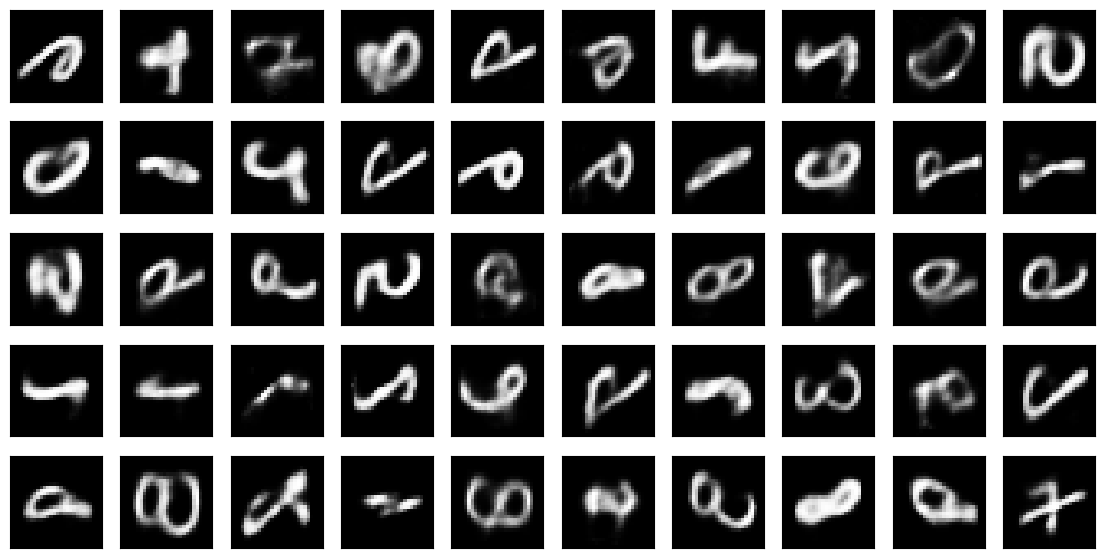

In [14]:
plot_samples(sample_vae(dec=dec))

In [15]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.dataset.data['images'][:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()

        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            if i % 5 == 0:
                axes[i % 5, 2 * (i // 5)].set_title("Orig")
                axes[i % 5, 2 * (i // 5) + 1].set_title("Recon")
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

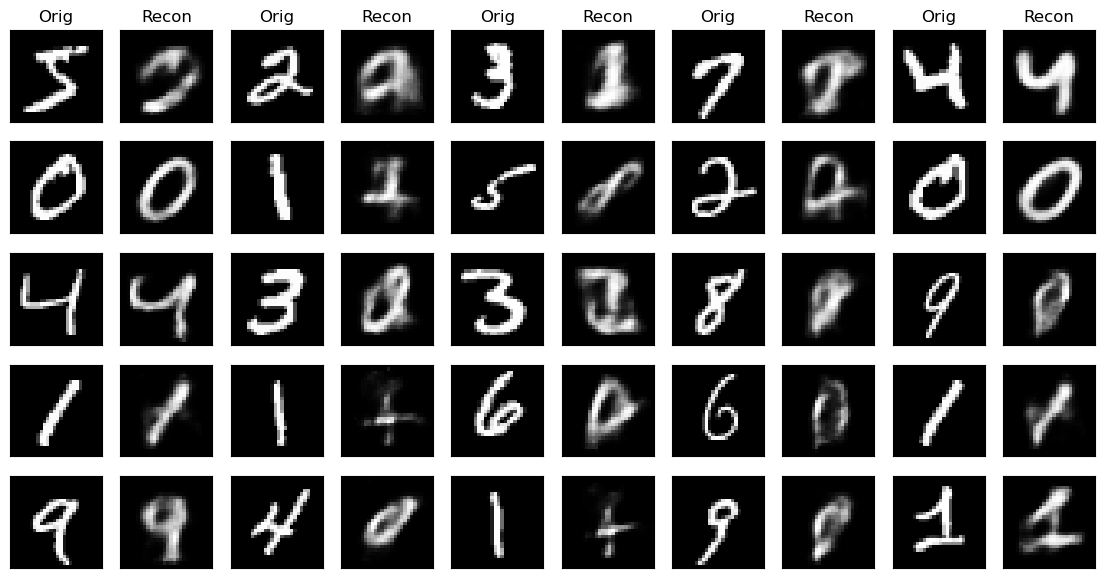

In [16]:
plot_reconstructions(loss_vae, [enc, dec])